#### Import libs

In [ ]:
!pip install simplejson

     |████████████████████████████████| 130 kB 12.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load


import simplejson as json

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import glob
import sys, time, os, warnings
warnings.filterwarnings("ignore")


import re
import collections
import random
import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from keras.layers.merge import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
tf.config.run_functions_eagerly(True)

### Load annotations

In [ ]:
filePath = '/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/annotations 2/'

In [ ]:
data = json.load(open( filePath + 'train.json', 'r'))
dataset = {}
for key, value in data.items():
  if key != 'annotations':
    dataset[key] = value
dataset['annotations'] = []
for annotation in data['annotations']:
  dataset['annotations'].append(annotation)

In [ ]:
dataset['annotations'][0]

{'caption': 'ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS THE NET WEIGHT TOO.',
 'id': 0,
 'image_id': 0,
 'is_precanned': False,
 'is_rejected': False,
 'text_detected': True}

#### Create the total list of captions and set of imageIds

In [ ]:
image_id = set()
captions = list()
for annotation in dataset['annotations']:
  image_id.add(annotation['image_id'])
  captions.append(annotation['caption'])

#### Convert to panda dataFrame

In [ ]:
df_annotations = pd.json_normalize(dataset, record_path =['annotations'])

In [ ]:
df_annotations

,caption,image_id,is_precanned,is_rejected,id,text_detected
0,ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS T...,0,False,False,0,True
1,A green and white plastic condiment bottle con...,0,False,False,1,True
2,Quality issues are too severe to recognize vis...,0,True,True,2,True
3,A bottle of spices in a plastic container layi...,0,False,False,3,True
4,some basil leaves in a container on a counter,0,False,False,4,True
...,...,...,...,...,...,...
117150,The back of a plastic card such as a credit ca...,23430,False,False,117150,True
117151,A card is seen with a scratch strip to reveal ...,23430,False,False,117151,True
117152,The back of a gift card without the silver str...,23430,False,False,117152,True
117153,The back of a plastic money or credit card wit...,23430,False,False,117153,True


#### Data Limiter

In [ ]:
df_annotations = df_annotations[0:15005]

In [ ]:
df_annotations

,caption,image_id,is_precanned,is_rejected,id,text_detected
0,ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS T...,0,False,False,0,True
1,A green and white plastic condiment bottle con...,0,False,False,1,True
2,Quality issues are too severe to recognize vis...,0,True,True,2,True
3,A bottle of spices in a plastic container layi...,0,False,False,3,True
4,some basil leaves in a container on a counter,0,False,False,4,True
...,...,...,...,...,...,...
15000,The cover of a book that states 100 reasons th...,3000,False,False,15000,True
15001,white note cards and a white book with black text,3000,False,False,15001,True
15002,Pieces of paper with what a snippet of a progr...,3000,False,False,15002,True
15003,White pages with black writing and an orange f...,3000,False,False,15003,True


#### Only consider isPrecanned = false captions as it was already rejectd as the spam 

In [ ]:
df_annotations_No_precanned = df_annotations[df_annotations["is_precanned"] == False]

In [ ]:
df_annotations_No_precanned = df_annotations_No_precanned.reset_index()

In [ ]:
df_annotations_No_precanned

,index,caption,image_id,is_precanned,is_rejected,id,text_detected
0,0,ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS T...,0,False,False,0,True
1,1,A green and white plastic condiment bottle con...,0,False,False,1,True
2,3,A bottle of spices in a plastic container layi...,0,False,False,3,True
3,4,some basil leaves in a container on a counter,0,False,False,4,True
4,5,A can of Coca Cola on a counter is shown for w...,1,False,False,5,True
...,...,...,...,...,...,...,...
13214,15000,The cover of a book that states 100 reasons th...,3000,False,False,15000,True
13215,15001,white note cards and a white book with black text,3000,False,False,15001,True
13216,15002,Pieces of paper with what a snippet of a progr...,3000,False,False,15002,True
13217,15003,White pages with black writing and an orange f...,3000,False,False,15003,True


In [ ]:
imageId = set(range(0, 3000))

#### List of imageIDs which are totally removed from the dataset after filtering the captions having pre_canned true. 

In [ ]:
imageIds = set() 
for i in range(len(df_annotations_No_precanned)):
  id = df_annotations_No_precanned["image_id"][i]
  imageIds.add(id)

In [ ]:
missing_imageIds = imageId.difference(imageIds)

In [ ]:
missing_imageIds

{19,
 30,
 155,
 262,
 273,
 292,
 308,
 347,
 481,
 594,
 605,
 606,
 677,
 792,
 819,
 1032,
 1037,
 1156,
 1217,
 1224,
 1340,
 1424,
 1484,
 1556,
 1565,
 1571,
 1630,
 1678,
 1804,
 1884,
 1997,
 2082,
 2092,
 2132,
 2211,
 2236,
 2321,
 2458,
 2566,
 2573,
 2587,
 2697,
 2881}

### make a dictionary to store image_id and corresponding captions

In [ ]:
imageId_path = dict()
for i in range(0, len(df_annotations_No_precanned)):
  id = df_annotations_No_precanned["image_id"][i]
  if( id not in missing_imageIds):
    number_str = str(id) 
    df_annotations_No_precanned["image_id"][i] = 'VizWiz_train_' + number_str.zfill(8) + '.jpg'
    imageId_path[df_annotations_No_precanned["image_id"][i]] = id
    print(df_annotations_No_precanned["image_id"][i])

Streaming output truncated to the last 5000 lines.
VizWiz_train_00001876.jpg
VizWiz_train_00001877.jpg
VizWiz_train_00001877.jpg
VizWiz_train_00001877.jpg
VizWiz_train_00001877.jpg
VizWiz_train_00001877.jpg
VizWiz_train_00001878.jpg
VizWiz_train_00001878.jpg
VizWiz_train_00001878.jpg
VizWiz_train_00001878.jpg
VizWiz_train_00001879.jpg
VizWiz_train_00001879.jpg
VizWiz_train_00001879.jpg
VizWiz_train_00001879.jpg
VizWiz_train_00001880.jpg
VizWiz_train_00001880.jpg
VizWiz_train_00001880.jpg
VizWiz_train_00001880.jpg
VizWiz_train_00001880.jpg
VizWiz_train_00001881.jpg
VizWiz_train_00001881.jpg
VizWiz_train_00001881.jpg
VizWiz_train_00001881.jpg
VizWiz_train_00001882.jpg
VizWiz_train_00001882.jpg
VizWiz_train_00001882.jpg
VizWiz_train_00001882.jpg
VizWiz_train_00001882.jpg
VizWiz_train_00001883.jpg
VizWiz_train_00001883.jpg
VizWiz_train_00001883.jpg
VizWiz_train_00001883.jpg
VizWiz_train_00001883.jpg
VizWiz_train_00001885.jpg
VizWiz_train_00001885.jpg
VizWiz_train_00001885.jpg
VizWiz_train_

### operation to convert the image_id to the name stored in the dataset.

In [ ]:
descriptions = dict()
for i in range(0, len(df_annotations_No_precanned)):
  caption = df_annotations_No_precanned["caption"][i]
  tokens = caption
  image_id = df_annotations_No_precanned["image_id"][i]
  if image_id not in descriptions:
    descriptions[image_id] = list()
  descriptions[image_id].append(tokens)

In [ ]:
len(descriptions)

2958

In [ ]:
list(descriptions.keys())[0:5]

['VizWiz_train_00000000.jpg',
 'VizWiz_train_00000001.jpg',
 'VizWiz_train_00000002.jpg',
 'VizWiz_train_00000003.jpg',
 'VizWiz_train_00000004.jpg']

### Visualize the image and captions

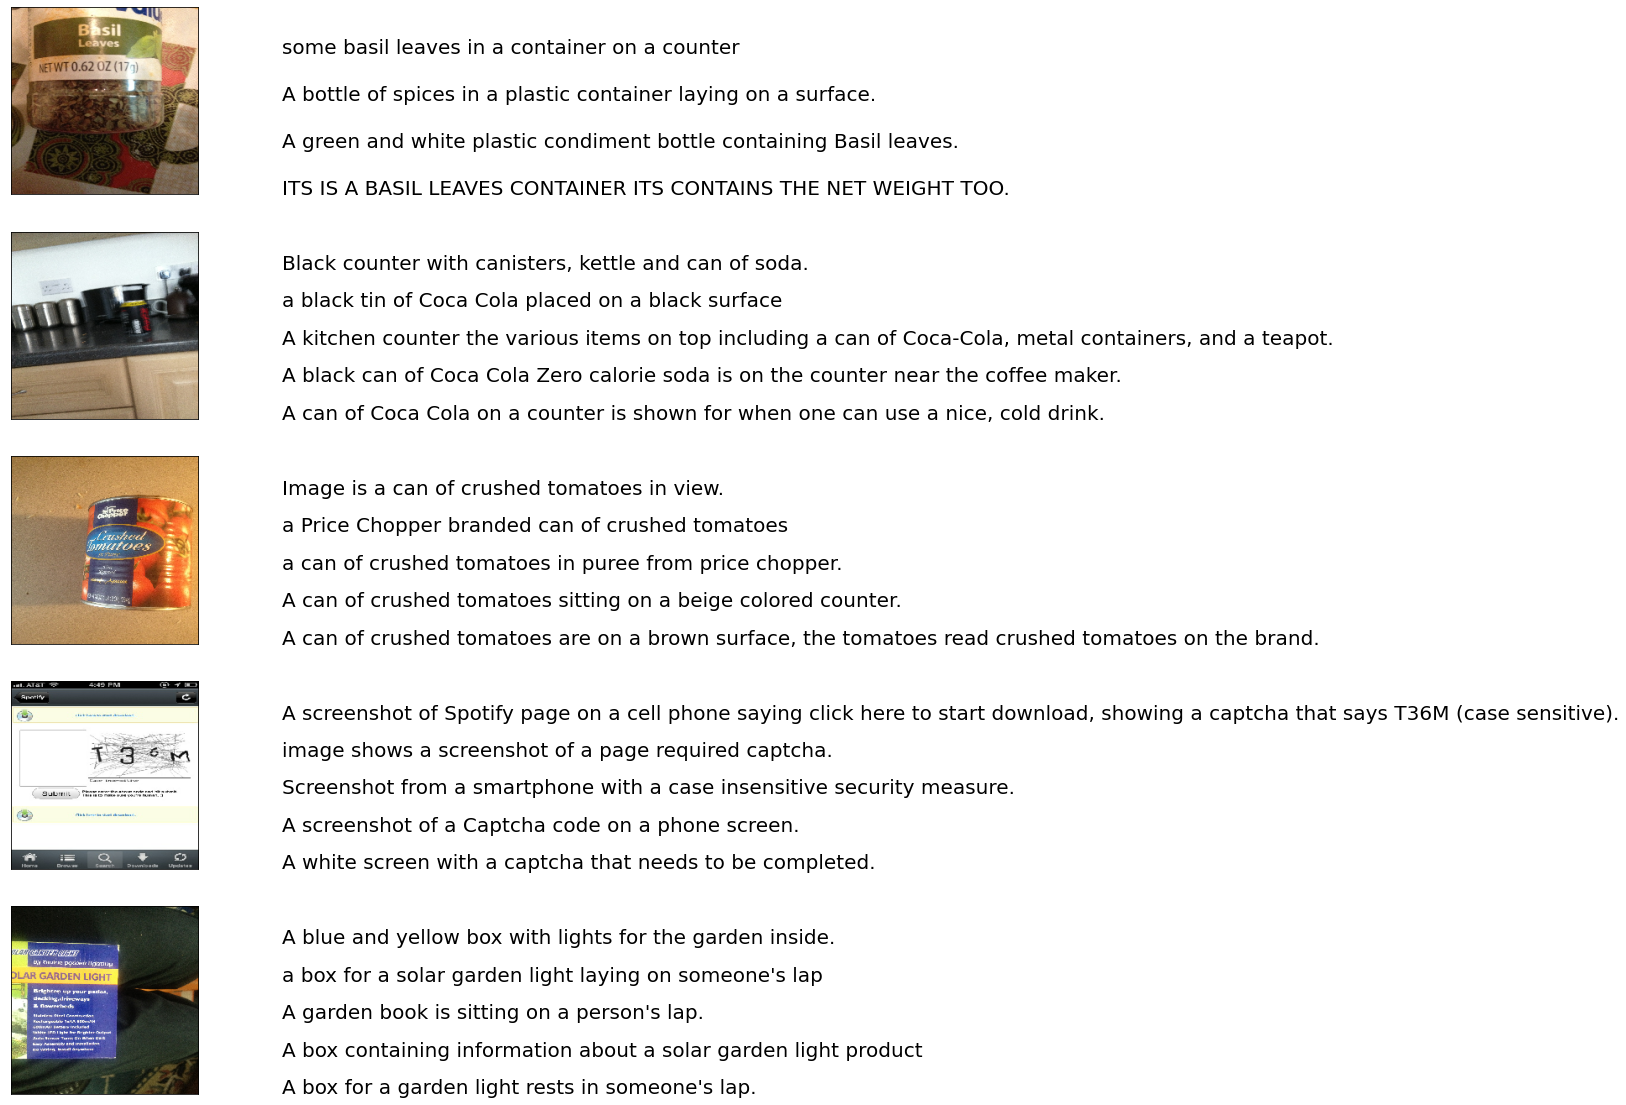

In [ ]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1
image_path = "/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/Dataset/train"
fig = plt.figure(figsize=(10,20))
for jpgfnm in list(descriptions.keys())[0:5]:
   filename = image_path + '/' + jpgfnm
   captions = list(df_annotations_No_precanned["caption"].loc[df_annotations_No_precanned["image_id"]==jpgfnm].values)
   image_load = load_img(filename, target_size=target_size)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=20)
   count += 1
plt.show()

### Text Processing utilities

In [ ]:
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

### Clean the captions reside in descriptions dict

In [ ]:
table = str.maketrans('', '', string.punctuation)
for image_id, captions in descriptions.items():
    for i in range(len(captions)):
        desc = captions[i].split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        captions[i] =  ' '.join(desc)

In [ ]:
descriptions["VizWiz_train_00000000.jpg"]

['its is a basil leaves container its contains the net weight too',
 'a green and white plastic condiment bottle containing basil leaves',
 'a bottle of spices in a plastic container laying on a surface',
 'some basil leaves in a container on a counter']

### Visualize the image with processed captions

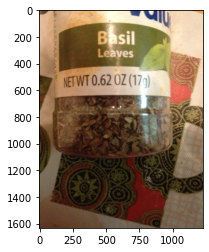

['its is a basil leaves container its contains the net weight too',
 'a green and white plastic condiment bottle containing basil leaves',
 'a bottle of spices in a plastic container laying on a surface',
 'some basil leaves in a container on a counter']

In [ ]:
images_path = "/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/Dataset/train/"
pic = 'VizWiz_train_00000000.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['VizWiz_train_00000000.jpg']

### Total vocabulary size

In [ ]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 7169


### Create list of image path

In [ ]:
img = glob.glob(images_path + '*.jpg')

In [ ]:
img[56][len(images_path):]

'VizWiz_train_00002322.jpg'

In [ ]:
train_images = list() 
count = 0
for key in descriptions.keys():
  train_images.append(key + ".jpg")
  count += 1

In [ ]:
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

In [ ]:
len(train_images)

2958

### Create train description dict with captions starting with startseq and ends with endsq

In [ ]:
train_descriptions = dict()
count = 0
for image_id , captions in descriptions.items(): 
    for i in range(len(captions)):
      desc = '<startseq> ' + ''.join(captions[i]) + ' <endseq>'
      if image_id not in train_descriptions:
        train_descriptions[image_id] = list()
      train_descriptions[image_id].append(desc)
      #descriptions[image_id][i] = desc
    count += 1

In [ ]:
len(train_descriptions)

2958

In [ ]:
train_descriptions['VizWiz_train_00000000.jpg']

['<startseq> its is a basil leaves container its contains the net weight too <endseq>',
 '<startseq> a green and white plastic condiment bottle containing basil leaves <endseq>',
 '<startseq> a bottle of spices in a plastic container laying on a surface <endseq>',
 '<startseq> some basil leaves in a container on a counter <endseq>']

### List of all captions

In [ ]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [ ]:
len(all_train_captions)

13219

### List of image with respective path

In [ ]:
PATH = "/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/Dataset/train/"

In [ ]:
all_train_imagepath = []
for key, val in train_descriptions.items():
  path = "/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/Dataset/train/" + key
  for cap in val:
      all_train_imagepath.append(path)

In [ ]:
len(all_train_imagepath)

### Again calculate vocabulary size

In [ ]:
vocab = []
for captions in descriptions.values():
   for caption in captions:
     vocab.extend(caption.split())
print('Clean Vocabulary Size: %d' % len(set(vocab)))

Clean Vocabulary Size: 7169


### Model definition

#### Utility function to load image for the desired size 

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

#### Download and do the transfer learning on the imagenet weights on InceptionV3 model 

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

### Create the feature vector and store them in the memory to save the RAM. 

In [ ]:
# Get unique images
encode_train = sorted(set(all_train_imagepath))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  print(path)
  batch_features = image_features_extract_model(img)
  print(len(batch_features[0]))
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

tf.Tensor(
[b'/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/Dataset/train/VizWiz_train_00000000.jpg'
 b'/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/Dataset/train/VizWiz_train_00000001.jpg'
 b'/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/Dataset/train/VizWiz_train_00000002.jpg'
 b'/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/Dataset/train/VizWiz_train_00000003.jpg'
 b'/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/Dataset/train/VizWiz_train_00000004.jpg'
 b'/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/Dataset/train/VizWiz_train_00000005.jpg'
 b'/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/Dataset/train/VizWiz_train_00000006.jpg'
 b'/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/Dataset/train/VizWiz_train_00000007.jpg'
 b'/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/Dataset/train/VizWiz_train_00000008.jpg'
 b'/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/Dataset/tr

#### Sample code for evaluating the feature vector size

In [ ]:
images_path = "/content/drive/MyDrive/Group Project - CMPE 258 (Fall 21)/Dataset/train/"
pic = 'VizWiz_train_00000000.jpg'
img, path = load_image(images_path+pic)
img = tf.expand_dims(img, axis=0)
features = image_features_extract_model(img)

In [ ]:
features.shape

TensorShape([1, 8, 8, 2048])

### Preprocess and tokenize the captions

In [ ]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
top_k = 8000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(all_train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
train_seqs = tokenizer.texts_to_sequences(all_train_captions)

#### Pas the each captions to the max length of the captions in the dataset to make the all the target variable size same.  

In [ ]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
cap_vector.shape

(13219, 81)

In [ ]:
max_length = calc_max_length(train_seqs)

In [ ]:
max_length

81

### Split the data into training and testing

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(all_train_imagepath, cap_vector):
  img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.99)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(13089, 13089, 130, 130)

### Configure the dataset to process it in batch 

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 64

In [ ]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

### Model

Motivation taken from [Image_captioning Show, Attend and tell paper](https://www.tensorflow.org/tutorials/text/image_captioning)

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

### Model Training

In [ ]:
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<startseq>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      for i in range(1, target.shape[1]):
         
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
for (img_tensor, target) in dataset.take(1):
  #print(img_tensor)
  print(target[:, 1])


tf.Tensor(
[   2    2   57    7    2    2    2    2    2  242    2  101   79    2
    2    2    2  388    2    7   21    2    2   27   44    2  178    2
    7    2    7    2    2    2    2    2    2 1588    2    2    2    7
    2    7    2   11    2    2  122    2   23  206    2    7    2    2
 1321    2   21    2    2   90    2   21], shape=(64,), dtype=int32)


In [ ]:
EPOCHS = 20

for epoch in range(0, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    loss_plot.append(total_loss / num_steps)

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 0.2087
Epoch 1 Batch 100 Loss 0.2055
Epoch 1 Batch 200 Loss 0.1787
Epoch 1 Loss 0.196143
Time taken for 1 epoch 301.77 sec

Epoch 2 Batch 0 Loss 0.1882
Epoch 2 Batch 100 Loss 0.1890
Epoch 2 Batch 200 Loss 0.1973
Epoch 2 Loss 0.185697
Time taken for 1 epoch 301.86 sec

Epoch 3 Batch 0 Loss 0.2194
Epoch 3 Batch 100 Loss 0.1832
Epoch 3 Batch 200 Loss 0.1914
Epoch 3 Loss 0.176203
Time taken for 1 epoch 302.05 sec

Epoch 4 Batch 0 Loss 0.1891
Epoch 4 Batch 100 Loss 0.1549
Epoch 4 Batch 200 Loss 0.1595
Epoch 4 Loss 0.167877
Time taken for 1 epoch 301.39 sec

Epoch 5 Batch 0 Loss 0.1740
Epoch 5 Batch 100 Loss 0.1497
Epoch 5 Batch 200 Loss 0.1782
Epoch 5 Loss 0.158126
Time taken for 1 epoch 301.99 sec

Epoch 6 Batch 0 Loss 0.1724
Epoch 6 Batch 100 Loss 0.1484
Epoch 6 Batch 200 Loss 0.1469
Epoch 6 Loss 0.149025
Time taken for 1 epoch 302.49 sec

Epoch 7 Batch 0 Loss 0.1459
Epoch 7 Batch 100 Loss 0.1400
Epoch 7 Batch 200 Loss 0.1428
Epoch 7 Loss 0.144011
Time taken for 1 epo

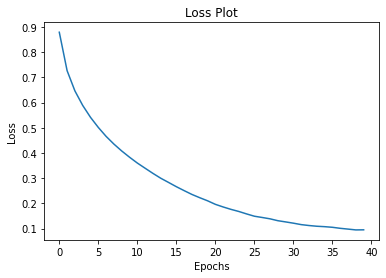

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

### Evaluation

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], axis=0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val,
                              (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<startseq>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<endseq>':
            return result[:-1], attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(7, 7))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

24
Real Caption: <startseq> a business card for ace cars with lots of text and numbers <endseq>
Prediction Caption: a small 5 flavored


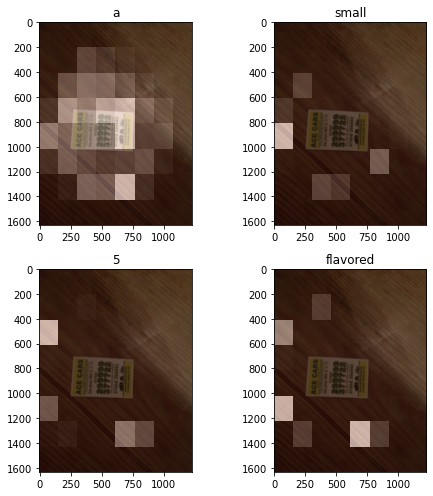

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
print(rid)
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [ ]:
# captions on the all validation images
rid = np.random.randint(0, len(img_name_val))
for rid in range(0, len(img_name_val)):
  print(rid)
  image = img_name_val[rid]
  real_caption = ' '.join([tokenizer.index_word[i]
                          for i in cap_val[rid] if i not in [0]])
  result, attention_plot = evaluate(image)

  print('Real Caption:', real_caption)
  print('Prediction Caption:', ' '.join(result))
  plot_attention(image, result, attention_plot)

Output hidden; open in https://colab.research.google.com to view.

#### Average Bleu score 

In [ ]:
num = 0
total_bleu_score = [0, 0, 0, 0]

results = {}
total_num = len(img_name_val)

max_bleu = [0, 0, 0, 0]
max_bleus_1 = {}
max_bleus_2 = {}
max_bleus_3 = {}
max_bleus_4 = {}

for image, ground_truth in zip(img_name_val , cap_val):

    #references = [sen.split() for sen in ground_truth]
    real_caption = ' '.join([tokenizer.index_word[i]
                        for i in ground_truth if i not in [0]])
    pic = key + ".jpg"
    
    # Load and Encode Image
    #image = encode_test("dataset/validation/" + pic).reshape((1, ENCODER_OUTPUT_DIM))
    result, attention_plot = evaluate(image)
    captions = []
    
    #print("Beam search... k=3  %d/%d" % (num, total_num), end='\r')  
    #captions.append(beam_search_predictions(image,3).split())
    
    results[key] = result
    

    total_bleu_score[0] += 100 * sentence_bleu(real_caption, result, weights=(1,0,0,0)) 
    total_bleu_score[1] += 100 * sentence_bleu(real_caption, result, weights=(0.5,0.5,0,0)) 
    total_bleu_score[2] += 100 * sentence_bleu(real_caption, result, weights=(0.33,0.33,0.33,0)) 
    total_bleu_score[3] += 100 * sentence_bleu(real_caption, result, weights=(0.25,0.25,0.25,0.25))    
        
    bleu_1 = 100 * sentence_bleu(real_caption, result, weights=(1,0,0,0)) 
    bleu_2 = 100 * sentence_bleu(real_caption, result, weights=(0.5,0.5,0,0)) 
    bleu_3 = 100 * sentence_bleu(real_caption, result, weights=(0.33,0.33,0.33,0)) 
    bleu_4 = 100 * sentence_bleu(real_caption, result, weights=(0.25,0.25,0.25,0.25))    
    
    if bleu_1 >= max_bleu[0]:
        max_bleu[0] = bleu_1
        max_bleus_1[pic] = (results[key], bleu_1)
    
    if bleu_2 >= max_bleu[1]:
        max_bleu[1] = bleu_2
        max_bleus_2[pic] = (results[key], bleu_2)
    
    if bleu_3 >= max_bleu[2]:
        max_bleu[2] = bleu_3
        max_bleus_3[pic] = (results[key], bleu_3)
    
    if bleu_4 >= max_bleu[3]:
        max_bleu[3] = bleu_4
        max_bleus_4[pic] = (results[key], bleu_4)
    
    num += 1
    
    
avg_bleu = [i/num for i in total_bleu_score]
print("Average: ",avg_bleu)
print("Total: ",total_bleu_score)

Average:  [10.178181387956945, 28.9642384557235, 42.05066216090178, 50.2829693034261]
Total:  [1323.1635804344028, 3765.350999244055, 5466.586080917232, 6536.786009445393]
